In [2]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import system.robot as robotSystem
import system.utils.dynamic_properties as part_properties
import numpy as np
import casadi as ca
from alpha_reach import Params as alpha_opt_params

In [6]:
alpha = robotSystem.RobotDynamics()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf','reach_alpha_5',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)

root = "base_link"
tip = "alpha_standard_jaws_base_link"

kinematic_dict, K, P, L, D, C, g, B, qdd, joint_torque, sys_id_coeff , F_payload = alpha.build_model(root, tip,
                                                                                                      floating_base=True, 
                                                                                                      has_endeffector=False)
c_parms, m_params, I_params, fv_coeff, fc_coeff, fs_coeff, v_s_coeff, vec_g, r_com_payload, m_p, q, q_dot, q_dotdot, tau, base_pose, world_pose = kinematic_dict['parameters']
n_joints = kinematic_dict['n_joints']
N = alpha.get_N()
D_dot_2C = alpha.get_D_dot_2C()
H = alpha.get_total_energy()
H_dot = alpha.get_total_power()
F_next = alpha.get_forward_simulation()
R_base = alpha.get_base_Reaction()
Y_id_reg = ca.Function('Y_reg',[q,q_dot,q_dotdot,vec_g,v_s_coeff,base_pose,world_pose], [alpha.Y])
Y_id_reg.save('arm_id_Y.casadi')

In [7]:
Base_ext_R_vehicle = ca.Function('R_base',[ca.vertcat(*c_parms), ca.vertcat(*m_params),ca.vertcat(*I_params),q,q_dot,q_dotdot,vec_g,world_pose,base_pose,m_p,r_com_payload],[R_base])

In [8]:
# # c , cpp or matlab code generation for forward simulation
# Base_ext_R_vehicle.generate("Base_ext_R_vehicle.c")
# os.system("gcc -fPIC -shared Base_ext_R_vehicle.c -o libBase_ext_R_vehicle.so")

In [9]:
# # # c , cpp or matlab code generation for forward simulation
# # F_next.generate("Mnext.c")
# # os.system("gcc -fPIC -shared Mnext.c -o libMnext.so")

sim_params = ca.vertcat(alpha._sys_id_coeff["masses_id_syms_vertcat"],
            alpha._sys_id_coeff["first_moments_id_vertcat"], 
            alpha._sys_id_coeff["inertias_id_vertcat"],
            alpha._sys_id_coeff["fv_id_vertcat"],
            alpha._sys_id_coeff["fc_id_vertcat"], 
            alpha._sys_id_coeff["fs_id_vertcat"],
            v_s_coeff, vec_g, r_com_payload, m_p, base_pose, world_pose)

# # c , cpp or matlab code generation for forward simulation
# alpha.F_next_reg.generate("Mnext.c")
# os.system("gcc -fPIC -shared Mnext.c -o libMnext.so")

# alpha.id2sim_params().save("id2sim_params.casadi")

# alpha.F_next_reg.save("xnext.casadi")

# alpha.id_D_reg_fun = ca.Function('alpha_id_D', [q, sim_params], [alpha.id_D])
# alpha.id_D_reg_fun.save("alpha_id_D.casadi")

# alpha.id_Cqot_reg_fun = ca.Function('alpha_id_Cqdot', [q_dot, sim_params], [alpha.Cqdot_reg])
# alpha.id_Cqot_reg_fun.save("alpha_id_Cqot.casadi")

# alpha.id_g_reg_fun = ca.Function('alpha_id_g', [q, sim_params], [alpha.id_g])
# alpha.id_g_reg_fun.save("alpha_id_g.casadi")

# alpha.id_B_reg_fun = ca.Function('alpha_id_B', [q_dot, sim_params], [alpha.B_reg])
# alpha.id_B_reg_fun.save("alpha_id_B.casadi")


In [10]:
L.size(), K.size(), P.size(), D.size(), g.size(), B.size()

((1, 1), (1, 1), (1, 1), (4, 4), (4, 1), (4, 1))

In [11]:
D_f = ca.Function('inertia_matrix', [ca.vertcat(*c_parms), 
                               ca.vertcat(*m_params),
                               ca.vertcat(*I_params),
                               vec_g,
                               q,
                               q_dot,
                               base_pose,
                               world_pose ],[K, D , C, g, D_dot_2C, N, P])

In [12]:
joint_min = np.array([1.00, 0.01, 0.01, 0.01])
joint_max = np.array([5.50, 3.40, 3.40, 5.70])
base_T0 = [0.190, 0.000, -0.120, np.pi, 0.000, 0.000] #floating base mount
# base_T1 = [0.0, 0.000, 0.0, 0.0, 0.000, 0.000] #fixed base mount
world_pose0 = [0.0, 0.0, 0, 0, 0, 0]
q_sample = np.array([5.23716914, 1.52230767, 0.08661294, 4.24328965])
c_sample = [0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0]
m_sample = [0.194, 0.429, 0.115, 0.333]
I_sample = [1e-2, 1e-2, 1e-2, 0, 0, 0, 1e-2, 1e-2, 1e-2, 0, 0, 0, 1e-2, 1e-2, 1e-2, 0, 0, 0, 1e-2, 1e-2, 1e-2, 0, 0, 0]
g_vec_sample = [0, 0, 9.81]
fv_sample = [2.0, 2.0, 2.0, 2.0]
fc_sample = [0.0, 0.0, 0.0, 0.0]
# fs_sample, v_s_sample = [0.0, 10.5, 0.5, 0.5], [10.0, 0.5, 0.5, 0.5]
fs_sample, v_s_sample = [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]
tau_sample = [0.2, 0.1, 0.3, 0.6]
qdot_sample = [0.21, 0.9, 0.13, 0.14]
qdotdot_sample = [0.0, 0.0, 0.0, 0.0]
r_com_payload_sample = [0.0, 0.0, 0.0]
m_p_sample = 0.0
dt_sample =0.04
n = alpha.kinematic_dict['n_joints']
mask = part_properties.lock_mask_from_indices(n, [])  # DM, 1 means locked
baumgarte_alpha = 2
x0_sample = ca.vertcat(q_sample, qdot_sample,)
kinetic_energy, robot_inertia_matrix, coriolis_matrix, gravity_vector, D_dot_2C_matrix, N_matrix, potential_energy = D_f(c_sample,
                                                                                                        m_sample,
                                                                                                        I_sample,
                                                                                                        g_vec_sample,
    q_sample,
    qdot_sample,
    base_T0,
    world_pose0
    )
rigid_p_sample = ca.vertcat(c_sample, m_sample, I_sample, fv_sample, fc_sample, fs_sample, v_s_sample, g_vec_sample, r_com_payload_sample, m_p_sample, base_T0, world_pose0)
x_next0 = alpha.F_next(x0_sample, tau_sample, dt_sample, rigid_p_sample, mask, baumgarte_alpha)


kinetic_energy, robot_inertia_matrix, coriolis_matrix, potential_energy, gravity_vector, x_next0

(DM(0.0145657),
 DM(
 [[0.0496372, -1.15084e-09, 4.97255e-08, -0.00134691], 
  [-1.15084e-09, 0.0382637, -0.0192923, -2.29548e-09], 
  [4.97255e-08, -0.0192923, 0.0204958, 2.95497e-19], 
  [-0.00134691, -2.29548e-09, 3.41259e-19, 0.01]]),
 DM(
 [[-0.00277364, 1.28464e-05, -0.000461069, 0.00381492], 
  [-1.28488e-05, 0.000197218, 0.00116813, -0.00104043], 
  [0.000461073, -0.00136535, -3.37292e-19, 0.00104044], 
  [0.00381492, 0.00104043, -0.00104044, 5.75087e-19]]),
 DM(-1.91568),
 DM([-4.42016e-17, -0.548326, -0.0980198, 0]),
 DM([5.24342, 1.54464, 0.0897831, 4.25442, 0.122676, 0.413303, 0.141217, 0.299068]))

In [13]:
mrc_lump, I_lump  = sys_id_coeff['first_moments'],  sys_id_coeff['inertias_vec6']


mrc_I_i_fun = ca.Function('mrc_I_i', [ca.vertcat(*c_parms), 
                               ca.vertcat(*m_params),
                               ca.vertcat(*I_params),
                               q,
                               base_pose,
                               world_pose ], [ca.vertcat(*mrc_lump), ca.vertcat(*I_lump)])

            
m_id_vec = sys_id_coeff['masses_id_syms_vertcat']
m_rci_id_vec = sys_id_coeff['first_moments_id_vertcat']
I_id_vec = sys_id_coeff['inertias_id_vertcat']
fv_id_vec = sys_id_coeff['fv_id_vertcat']
fc_id_vec = sys_id_coeff['fc_id_vertcat']
fs_id_vec = sys_id_coeff['fs_id_vertcat']
 
reg_fun = ca.Function('reg', [m_id_vec, m_rci_id_vec, I_id_vec, vec_g, q,q_dot,base_pose,world_pose],[alpha.id_K, alpha.id_D, alpha.id_C, alpha.id_P, alpha.id_g])

mrc_lump_sample , I_lump_sample =  mrc_I_i_fun(c_sample, m_sample, I_sample ,q_sample, base_T0, world_pose0)
id_kinetic_energy, id_robot_inertia_matrix, id_coriolis_matrix, id_potential_energy, id_gravity_vector = reg_fun(m_sample, mrc_lump_sample, I_lump_sample, g_vec_sample, q_sample, qdot_sample, base_T0, world_pose0)
rigid_p_id_sample = ca.vertcat(m_sample, mrc_lump_sample, I_lump_sample,fv_sample,fc_sample, fs_sample, v_s_sample, g_vec_sample,r_com_payload_sample,m_p_sample,base_T0, world_pose0)

x_nextid0 = alpha.F_next_reg(x0_sample, tau_sample, dt_sample, rigid_p_id_sample, mask, baumgarte_alpha)
id_kinetic_energy, id_robot_inertia_matrix, id_coriolis_matrix, id_potential_energy, id_gravity_vector , x_nextid0

(DM(0.0145657),
 DM(
 [[0.0496372, -1.15084e-09, 4.97255e-08, -0.00134691], 
  [-1.15084e-09, 0.0382637, -0.0192923, -2.29548e-09], 
  [4.97255e-08, -0.0192923, 0.0204958, 4.80281e-19], 
  [-0.00134691, -2.29548e-09, 3.4126e-19, 0.01]]),
 DM(
 [[-0.00277364, 1.28464e-05, -0.000461069, 0.00381492], 
  [-1.28488e-05, 0.000197218, 0.00116813, -0.00104043], 
  [0.000461073, -0.00136535, 1.05767e-19, 0.00104044], 
  [0.00381492, 0.00104043, -0.00104044, -7.59628e-21]]),
 DM(-1.91568),
 DM([-4.42016e-17, -0.548326, -0.0980198, 0]),
 DM([5.24342, 1.54464, 0.0897831, 4.25442, 0.122676, 0.413303, 0.141217, 0.299068]))

In [14]:
tol = 1e-10
errs = {
    "K": float(ca.norm_inf(kinetic_energy - id_kinetic_energy)),
    "D": float(ca.norm_inf(robot_inertia_matrix - id_robot_inertia_matrix)),
    "C": float(ca.norm_inf(coriolis_matrix - id_coriolis_matrix)),
    "P": float(ca.norm_inf(potential_energy - id_potential_energy)),
    "g": float(ca.norm_inf(gravity_vector - id_gravity_vector)),
    "fsim": float(ca.norm_inf(x_next0 - x_nextid0)),
}
print(errs, {k: (v < tol) for k, v in errs.items()})

{'K': 5.204170427930421e-18, 'D': 6.938893903907228e-18, 'C': 3.2526065174565133e-18, 'P': 0.0, 'g': 1.1102230246251565e-16, 'fsim': 5.551115123125783e-17} {'K': True, 'D': True, 'C': True, 'P': True, 'g': True, 'fsim': True}


In [15]:
J_tip = kinematic_dict["geo_J"][-1]   # 6×n geometric Jacobian at the tool
SYS_ID_FUN = ca.Function('SYS_ID_TAU', [m_id_vec, m_rci_id_vec, I_id_vec, fv_id_vec, fc_id_vec, fs_id_vec, v_s_coeff, vec_g, r_com_payload, m_p, q, q_dot, q_dotdot, base_pose,world_pose],[alpha.Y@alpha.id_theta + J_tip.T@F_payload])
SYS_ID_Y_FUN = ca.Function('SYS_ID_Y', [v_s_coeff, vec_g, r_com_payload, m_p, q,q_dot, q_dotdot, base_pose,world_pose],[alpha.Y])

SYS_ID_FUN(m_sample, mrc_lump_sample, I_lump_sample, fv_sample, fc_sample, fs_sample, v_s_sample, g_vec_sample, r_com_payload_sample, m_p_sample, q_sample, qdot_sample, qdotdot_sample, base_T0, world_pose0)

DM([0.419903, 1.25185, 0.160994, 0.281602])

In [17]:
Inverse_ID_FUN =ca.Function('Inverse_dynamics_tau', [ca.vertcat(*c_parms), ca.vertcat(*m_params), ca.vertcat(*I_params), fv_coeff, fc_coeff, fs_coeff, v_s_coeff,
                                                     vec_g, r_com_payload, m_p, q, q_dot, q_dotdot, base_pose, world_pose], [alpha.get_inverse_dynamics()])
Inverse_ID_FUN(c_sample,m_sample,I_sample, fv_sample, fc_sample, fs_sample, v_s_sample, g_vec_sample, r_com_payload_sample, m_p_sample, q_sample, qdot_sample, qdotdot_sample, base_T0, world_pose0)

DM([0.419903, 1.25185, 0.160994, 0.281602])

In [18]:
for i in range(10000):
    joint_min = np.array([1.00, 0.01, 0.01, 0.01])
    joint_max = np.array([5.50, 3.40, 3.40, 5.70])
    q_sample = np.random.uniform(joint_min, joint_max)

    kinetic_energy, robot_inertia_matrix, coriolis_matrix, gravity_vector, D_dot_2C_matrix, N_matrix, potential_energy = D_f(c_sample,
                                                                                                            m_sample,
                                                                                                            I_sample,
                                                                                                            g_vec_sample,
        q_sample,
        qdot_sample,
        base_T0,
        world_pose0
        )

    checks_pass = part_properties.is_spd_strict(robot_inertia_matrix) and part_properties.is_skew_symmetric(N_matrix) and np.allclose(D_dot_2C_matrix, N_matrix)
    if not checks_pass:
        raise ValueError(f"check failed for q:{q_sample}")

q_hist shape: (1000, 4)
qd_hist shape: (1000, 4)
t_hist shape: (1000,)


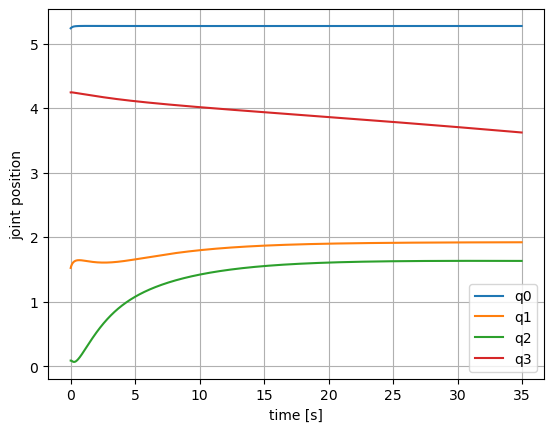

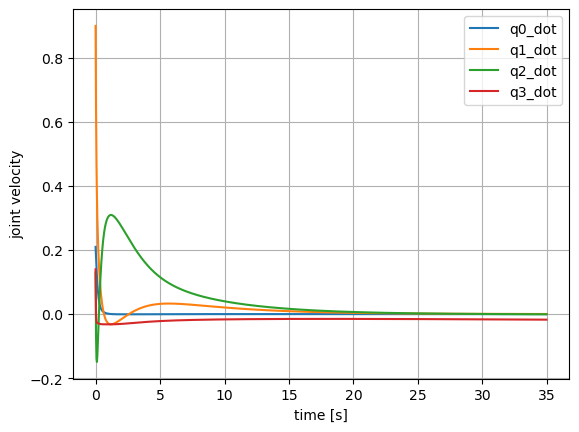

In [19]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000

q_hist = []
qd_hist = []
t_hist = []

x = x0_sample

for k in range(N):
    # store current state
    q_hist.append(np.array(x[:4], dtype=float).ravel())
    qd_hist.append(np.array(x[4:], dtype=float).ravel())
    t_hist.append(k * alpha_opt_params.delta_t)

    # propagate
    x = alpha.F_next_reg(
        x,
        [0, 0, 0, 0],
        alpha_opt_params.delta_t,
        alpha_opt_params.sim_p,
        [0, 0, 0, 0],
        2,
    )

# convert to arrays with shape (N, 4)
q_hist = np.array(q_hist, dtype=float).reshape(-1, 4)
qd_hist = np.array(qd_hist, dtype=float).reshape(-1, 4)
t_hist = np.array(t_hist, dtype=float)

print("q_hist shape:", q_hist.shape)
print("qd_hist shape:", qd_hist.shape)
print("t_hist shape:", t_hist.shape)

# plot joint positions
plt.figure()
for j in range(4):
    plt.plot(t_hist, q_hist[:, j], label=f"q{j}")
plt.xlabel("time [s]")
plt.ylabel("joint position")
plt.legend()
plt.grid(True)

# plot joint velocities
plt.figure()
for j in range(4):
    plt.plot(t_hist, qd_hist[:, j], label=f"q{j}_dot")
plt.xlabel("time [s]")
plt.ylabel("joint velocity")
plt.legend()
plt.grid(True)

plt.show()
